# Predicting Time Spent at Home: Insights from the American Time Use Survey

## Objective:

This project focuses on predicting the amount of time individuals spend at home daily based on various socio-economic and demographic factors. Using the American Time Use Survey (ATUS) data (2010-2019), the goal was to engineer meaningful features, preprocess the data effectively, and build robust predictive models.

In [61]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from tqdm import tqdm
from IPython.display import clear_output

## Functions

In [63]:
def load_and_merge_datasets(year, extension='dat'):
    """
    Load and merge the required datasets for a given year.

    Parameters:
    year (int): The year for which the datasets should be loaded.
    extension (str, optional): The file extension of the datasets. Defaults to 'dat'.

    Returns:
    pd.DataFrame: The merged DataFrame.
    """
    # Load datasets
    print('Loading datasets...')
    cols_to_select = ['TEAGE', 'TELFS', 'TESEX', 'TRCHILDNUM', 'TRHHCHILD', 'TRHOLIDAY', 'TRNHHCHILD', 'TRNUMHOU', 'TROHHCHILD', 'TRSPPRES',
                  'TRTFAMILY', 'TRTFRIEND', 'TRTALONE', 'TRTCC', 'TRTCCC', 'GEDIV', 'GEREG', 'GTMETSTA', 'HEFAMINC', 'HEHOUSUT',
                  'HRHTYPE', 'PEHSPNON', 'PEEDUCA', 'PEMARITL', 'PRDISFLG', 'PTDTRACE', 'ageGroup', 'WEEKEND', 'TUACTDUR24']
    resp_cols = ['TUCASEID'] + ['TRCHILDNUM', 'TRHHCHILD', 'TRHOLIDAY', 'TRNHHCHILD', 'TRNUMHOU', 'TROHHCHILD', 'TRSPPRES',
                  'TRTFAMILY', 'TRTFRIEND', 'TRTALONE', 'TRTCC', 'TRTCCC', 'TELFS', 'TUDIARYDAY', 'TUFINLWGT']
    rost_cols = ['TUCASEID', 'TEAGE', 'TESEX']
    activity_cols = ['TUCASEID', 'TUACTIVITY_N', 'TUACTDUR24', 'TEWHERE', 'TRCODE']
    cps_cols = ['TUCASEID', 'GEREG', 'GTMETSTA', 'HEFAMINC', 'HEHOUSUT', 'HRHTYPE', 'PEHSPNON', 'PEEDUCA', 'PEMARITL', 'PRDISFLG', 'PTDTRACE', 'TULINENO']
    resp = pd.read_csv(f'./{year}/atusresp_{year}.{extension}', usecols=resp_cols)  
    rost = pd.read_csv(f'./{year}/atusrost_{year}.{extension}', usecols=rost_cols)
    activity = pd.read_csv(f'./{year}/atusact_{year}.{extension}', usecols=activity_cols)
    cps = pd.read_csv(f'./{year}/atuscps_{year}.{extension}', usecols=cps_cols)
    
    # Filter cps dataset
    mask = cps['TULINENO'] == 1
    cps = cps[mask]

    print('Merging datasets...')
    # Merge the datasets on 'TUCASEID'
    merged_df = pd.merge(rost, activity, on='TUCASEID', suffixes=('_df1', '_df2'))
    merged_df = pd.merge(merged_df, resp, on='TUCASEID', suffixes=('', '_df3'))
    merged_df = pd.merge(merged_df, cps, on='TUCASEID', suffixes=('', '_df4'))

    # Drop repeated columns (keeping only the first occurrence)
    columns_to_drop = [col for col in merged_df.columns if '_df' in col]
    allData = merged_df.drop(columns=columns_to_drop)
    
    print('Done.\n')
    return allData

def prepare_at_home_data(allData, year):
    """
    Prepare the atHome23 DataFrame by filtering, transforming, and selecting columns.
    
    Parameters:
    allData (pd.DataFrame): The input DataFrame to process.
    year (int): The year for which the data is being prepared.
    
    Returns:
    pd.DataFrame: The prepared DataFrame.
    """
    print('Preparing data...')
    # Filter the DataFrame based on conditions
    atHome = allData[
        (allData['TEWHERE'].isin([1, 3])) | 
        (allData['TRCODE'].isin([10101, 10102, 10199]))
    ].reset_index(drop=True)

    # Create 'WEEKEND' column
    atHome['WEEKEND'] = atHome['TUDIARYDAY'].apply(lambda x: 1 if x in [1, 7] else 0)

    # Convert duration to hours
    atHome['TUACTDUR24'] /= 60

    # Define age bins and labels
    age_bins = [0, 18, 35, 50, 65, 75, np.inf]
    age_labels = ['0-18', '19-35', '36-50', '51-65', '66-75', '75+']

    # Create ageGroup column
    atHome['ageGroup'] = pd.cut(atHome['TEAGE'], bins=age_bins, labels=age_labels, right=False)
    
    print('Done.\n')
    return atHome

def check_single_cycle(data):
    """
    Filters out single cycles from the given data.

    Parameters:
    data (DataFrame): The input data containing activity information.

    Returns:
    DataFrame: The filtered data with single cycles removed.
    """
    def filter_cycles(group):
        seen_activities = set()
        first_cycle_end = len(group)
        
        for i, activity_num in enumerate(group['TUACTIVITY_N']):
            if activity_num in seen_activities:
                first_cycle_end = i
                break
            seen_activities.add(activity_num)
        
        return group.iloc[:first_cycle_end]
    
    print('Checking for single cycles...')
    data = data.groupby('TUCASEID').apply(filter_cycles).reset_index(drop=True)
    print('Done.\n')
    return data

def check_duration_over_24_hours(df):
    """
    Checks if the total duration of activities for each TUCASEID in the given DataFrame exceeds 24 hours.

    Args:
        df (DataFrame): The DataFrame containing the activity data.

    Raises:
        ValueError: If there are any TUCASEID(s) with a total duration over 24 hours.

    Returns:
        None
    """
    # Group by TUCASEID and sum the TUACTDUR24 column, then divide by 60 to convert to hours
    duration_sum = df.groupby('TUCASEID')['TUACTDUR24'].sum()

    # Filter to find TUCASEID where the sum of durations is over 24 hours
    over_24_hours = duration_sum[duration_sum > 24]
    print('Checking for bad records...')
    # Check if there are any IDs with total durations over 24 hours
    if not over_24_hours.empty:
        bad_ids = over_24_hours.index.tolist()
        raise ValueError(f"Found TUCASEID(s) with total duration over 24 hours: {over_24_hours.index.tolist()}")
    else:
        print("There are no bad records.\n")

def clean_at_home_data(atHomeData):
    """
    Process the atHome23 DataFrame by grouping, aggregating, and renaming columns.
    
    Parameters:
    atHome23 (pd.DataFrame): The input DataFrame to process.
    
    Returns:
    pd.DataFrame: The processed DataFrame.
    """
    # Group and aggregate the DataFrame
    print('Grouping and aggregating data...')

    # List of columns to keep the first entry for
    columns_to_keep_first = atHomeData.columns.difference(['TUACTDUR24', 'TUCASEID'])

    # Create the aggregation dictionary
    agg_dict = {col: 'first' for col in columns_to_keep_first}
    agg_dict['TUACTDUR24'] = 'sum'

    # Group and aggregate the data
    grouped_atHomeData = atHomeData.groupby('TUCASEID').agg(agg_dict).reset_index()

    # Drop the 'TUCASEID' column
    grouped_atHomeData = grouped_atHomeData.drop(columns=['TUCASEID'])
    
    grouped_atHomeData['ageGroup'] = grouped_atHomeData['ageGroup'].astype('category')

    print('Imputing missing values...')
    # Find columns with missing values
    missing_cols = grouped_atHomeData.columns[grouped_atHomeData.isnull().any()]
    if missing_cols.empty:
        print('No missing values found.')
    else:
        # Impute missing values using the most frequent value
        imputer = SimpleImputer(strategy='most_frequent')
        grouped_atHomeData[missing_cols] = imputer.fit_transform(grouped_atHomeData[missing_cols])

    numeric_cols = grouped_atHomeData.columns[grouped_atHomeData.dtypes != 'category']
    for col in numeric_cols:
        grouped_atHomeData[col] = pd.to_numeric(grouped_atHomeData[col], errors='ignore')

    print('Done.\n')
    return grouped_atHomeData


## Code Explanation

The code cell is performing the following tasks:

1. Loading and Merging Datasets:
    - The function `load_and_merge_datasets(year, extension='dat')` is defined to load and merge multiple datasets for a given year.
    - It takes two parameters: `year` (int) - the year for which the datasets should be loaded, and `extension` (str, optional) - the file extension of the datasets (default is 'dat').
    - The function loads four datasets: `atusresp`, `atusrost`, `atusact`, and `atuscps` for the specified year.
    - It filters the `atuscps` dataset to keep only the records where `TULINENO` is equal to 1 (primary respondent).
    - It then filters each file to keep only those columns which are useful for the purposes of building predictive models. Further discussion is done in a separate notebook.
    - Then, it merges the datasets based on the common column `TUCASEID` using the `pd.merge()` function.
    - The merged DataFrame is stored in the variable `allData`.

2. Preparing the at Home Data:
    - The function `prepare_at_home_data(allData, year)` is defined to prepare the atHome DataFrame by filtering, transforming, and selecting columns.
    - It takes two parameters: `allData` (pd.DataFrame) - the input DataFrame to process, and `year` (int) - the year for which the data is being prepared.
    - The function filters the DataFrame based on certain conditions using boolean indexing.
    - It creates a new column `WEEKEND` based on the values in the `TUDIARYDAY` column.
    - It converts the duration column `TUACTDUR24` from minutes to hours.
    - It creates a new column `ageGroup` based on the values in the `TEAGE` column using predefined age bins and labels.
    - It selects the relevant columns from the DataFrame and stores the result in the variable `atHome`.

3. Checking for Single Cycles:
    - The function `check_single_cycle(data)` is defined to filter out single cycles from the given data.
    - It takes one parameter: `data` (DataFrame) - the input data containing activity information.
    - The function groups the data by `TUCASEID` and applies a filter to remove any activities that are repeated within the same cycle.
    - It keeps only the activities before the first occurrence of a repeated activity.
    - The filtered data is returned as the result.

The purpose of the `check_single_cycle` function is to identify and keep single cycles from the data. A single cycle refers to a sequence of activities that are performed by the same person in a day. If a household has multiple members who filled out the survey, it stores the activities of all people with the same TUCASEID. When we group by ID to aggregate daily averages, this would create erroneous data. The current solution is to only take yhe primary person's data. Future solutions could include splitting one ID into multiple and storing each person's data.

The function works by grouping the data by `TUCASEID`, which represents a unique identifier for each household. For each group, it iterates through the activity number and checks if a number has been seen before. If a repeated number is found, it marks the index of the first occurrence of the repeated activity as the end of the cycle. It then selects only the activities before the end of the cycle and returns the filtered data.

Overall, the code cell loads and merges datasets, prepares the at Home data by filtering and transforming it, and applies a check to remove single cycles from the data. These steps are essential for data preprocessing and ensuring the quality of the dataset for further analysis or modeling.

## Loading all data

For this notebook, we are only looking at pre-Covid data: (2010 - 2019)

In [64]:
def main(year, extension='dat'):
    """
    Process the data for a given year and return the grouped data.

    Parameters:
    year (int): The year for which the data needs to be processed.
    extension (str, optional): The file extension of the datasets. Defaults to 'dat'.

    Returns:
    groupedData (DataFrame): The cleaned and grouped data.

    Raises:
    ValueError: If the duration of any activity is over 24 hours.

    """
    print(f'Processing data for year {year}...\n')
    allData = load_and_merge_datasets(year, extension)
    atHomeData = prepare_at_home_data(allData, year)
    atHomeData = check_single_cycle(atHomeData)
    try:
        check_duration_over_24_hours(atHomeData)
    except ValueError as e:
        print(e)
    groupedData = clean_at_home_data(atHomeData)
    return groupedData

In [165]:
years = [2010, 2014, 2015, 2016, 2017, 2018, 2019]
full_data = pd.DataFrame()
for year in tqdm(years, desc="Processing years"):
    if year in [2018, 2019, 2020]:
        df = main(year, extension='csv')
    else:
        df = main(year, extension='dat')
    full_data = pd.concat([full_data, df])

    clear_output(wait=True)
    print(f"Finished processing for year {year}")

Processing years: 100%|██████████| 7/7 [00:18<00:00,  2.59s/it]

Finished processing for year 2019


In [166]:
cols_to_select = ['TEAGE', 'TELFS', 'TESEX', 'TRCHILDNUM', 'TRHHCHILD', 'TRHOLIDAY', 'TRNHHCHILD', 'TRNUMHOU', 'TROHHCHILD', 'TRSPPRES',
                  'TRTFAMILY', 'TRTFRIEND', 'TRTALONE', 'TRTCC', 'TRTCCC', 'GEREG', 'GTMETSTA', 'HEFAMINC', 'HEHOUSUT',
                  'HRHTYPE', 'PEHSPNON', 'PEEDUCA', 'PEMARITL', 'PRDISFLG', 'PTDTRACE', 'ageGroup', 'WEEKEND', 'TUACTDUR24', 'TUFINLWGT']

numeric_cols = ['TEAGE', 'TRCHILDNUM', 'TRNUMHOU', 'TRTFAMILY', 'TRTFRIEND', 'TRTALONE', 'TRTCC', 'TUACTDUR24', 'TRTCCC', 'TUFINLWGT']
ordinal_cols = ['PEEDUCA', 'ageGroup', 'HEFAMINC']

cat_cols = list(set(cols_to_select) - set(numeric_cols) - set(ordinal_cols))

full_data = full_data[cols_to_select]

# convert categorical columns to category type
full_data[cat_cols] = full_data[cat_cols].astype('category')

In [167]:
full_data.head()

,TEAGE,TELFS,TESEX,TRCHILDNUM,TRHHCHILD,TRHOLIDAY,TRNHHCHILD,TRNUMHOU,TROHHCHILD,TRSPPRES,...,HRHTYPE,PEHSPNON,PEEDUCA,PEMARITL,PRDISFLG,PTDTRACE,ageGroup,WEEKEND,TUACTDUR24,TUFINLWGT
0,30,1,2,4,1,0,2,6,1,3,...,4,2,40,6,2,2,19-35,1,6.500000,1.482766e+06
1,27,1,2,1,1,0,2,2,1,3,...,4,2,39,6,2,1,19-35,1,17.500000,2.771434e+06
2,20,1,1,1,1,0,2,4,1,1,...,1,1,37,1,2,1,19-35,0,22.966667,1.709309e+07
3,69,5,2,0,2,0,2,1,2,3,...,7,2,40,4,2,14,66-75,0,22.666667,7.976843e+06
4,31,4,2,0,2,0,2,1,2,3,...,7,2,41,6,2,1,19-35,1,21.133333,3.661488e+06


In [168]:
full_data_old = full_data.copy()

## Feature Engineering

These are a few steps I took to enhance the information conveyed by some of the features.

1. `PTDTRACE` contains a wide variety of people from different races. However, the distribution is very lopsided. There are many more white people in the survey than all other categories combined. In my opinion, a better feature would be `White/Non-White`. This reduces dimensionality, offering more stability to the tree models. 

2. A similar condensation process is applied to other categorical columns such as `HEFAMINC` (Income Level), `PEEDUCA`(Education Level), `Num_People` (Number of people in household), `Num_Children` (Number of children in household), and `Num_Adults` (Number of adult in household). The minority classes simply do not have enough data points to contribute anything meaningful. Including them may induce overfitting on said minority groups. For reference, look at the boxplots which compare the distribution of time spent at home for each category. It may look like there is considerable variance across categories, however the category distribution tells us there just aren't enough minority samples for the data to be meaningful. For example, for `PTDTRACE`=11, there is a noticeable change in the time spent at home, however, there are only 8 samples of that particular race. 

In [169]:
# Feature Engineering
full_data['PTDTRACE'] = full_data['PTDTRACE'].apply(lambda x: 1 if x == 1 else 0)
full_data['Num_People'] = full_data['TRNUMHOU'].apply(lambda x: 4 if x >= 4 else x)
full_data['Num_Children'] = full_data['TRCHILDNUM'].apply(lambda x: 3 if x >= 3 else x)                                                                                         
full_data['Num_Adults'] = full_data['TRNUMHOU'] - full_data['TRCHILDNUM']
full_data['Num_Adults'] = full_data['Num_Adults'].apply(lambda x: 3 if x >= 3 else x)
full_data['Num_Children'] = full_data['Num_Children'].astype('category')
full_data['Num_Adults'] = full_data['Num_Adults'].astype('category')
full_data['Num_People'] = full_data['Num_People'].astype('category')

full_data = full_data.drop(columns=['TRNUMHOU', 'TRCHILDNUM'])
numeric_cols.remove('TRNUMHOU')
numeric_cols.remove('TRCHILDNUM')
ordinal_cols.append('Num_Children')
ordinal_cols.append('Num_Adults')
ordinal_cols.append('Num_People')

# # Age Normalization of TRTFAMILY, TRTFRIEND, TRTALONE, TRTCC, TRTCCC
# full_data['TRTFAMILY'] = full_data['TRTFAMILY'] / full_data['TEAGE']
# full_data['TRTFRIEND'] = full_data['TRTFRIEND'] / full_data['TEAGE']
# full_data['TRTALONE'] = full_data['TRTALONE'] / full_data['TEAGE']
# full_data['TRTCC'] = full_data['TRTCC'] / full_data['TEAGE']
# full_data['TRTCCC'] = full_data['TRTCCC'] / full_data['TEAGE']

#Drop TEAGE
numeric_cols.remove('TEAGE')
# Condense PEEDUCA
full_data['PEEDUCA'] = full_data['PEEDUCA'].apply(lambda x: 0 if x<= 38 else (1 if x == 39 else (2 if 40 <= x <= 42 else (3 if x==43 else (4 if x>=43 else x)))))

# Condense HEFAMINC
full_data['HEFAMINC'] = full_data['HEFAMINC'].apply(lambda x: 0 if x<= 5 else (1 if  5< x <= 10 else (2 if 11 <= x <= 14 else 3)))

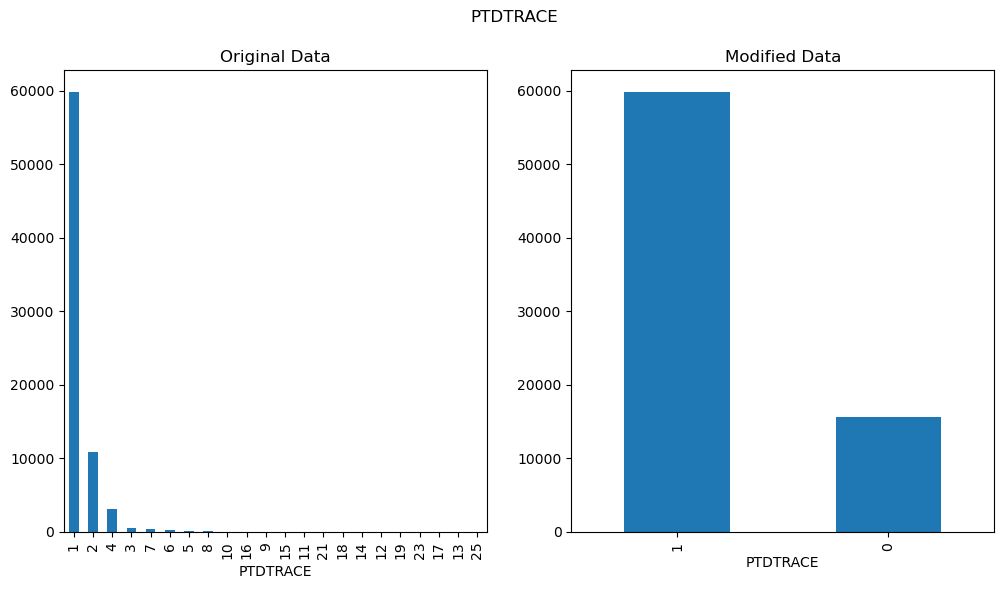

In [170]:
# Compare and plot the original and modified data, starting with PTDTRACE
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
full_data_old['PTDTRACE'].value_counts().plot(kind='bar', ax=ax[0])
ax[0].set_title('Original Data')
full_data['PTDTRACE'].value_counts().plot(kind='bar', ax=ax[1])
ax[1].set_title('Modified Data')
plt.suptitle('PTDTRACE')
plt.show()

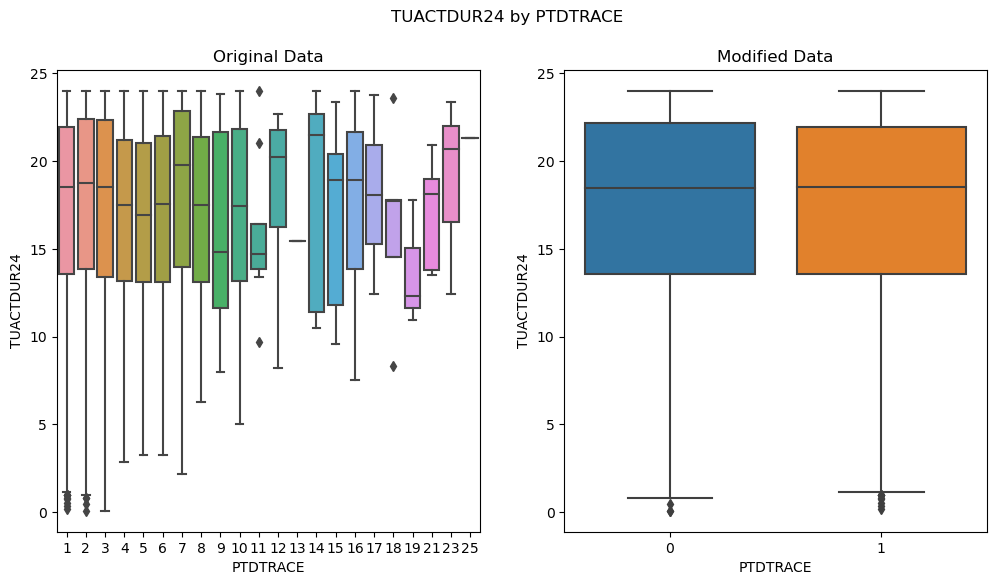

In [171]:
# Boxplots of TUACTDUR24 for each Race (old vs new)
import seaborn as sns
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.boxplot(x='PTDTRACE', y='TUACTDUR24', data=full_data_old, ax=ax[0])
ax[0].set_title('Original Data')
sns.boxplot(x='PTDTRACE', y='TUACTDUR24', data=full_data, ax=ax[1])
ax[1].set_title('Modified Data')
plt.suptitle('TUACTDUR24 by PTDTRACE')
plt.show()

In [163]:
mask = full_data_old['PTDTRACE'] == 11
full_data_old[mask]

,TEAGE,TELFS,TESEX,TRCHILDNUM,TRHHCHILD,TRHOLIDAY,TRNHHCHILD,TRNUMHOU,TROHHCHILD,TRSPPRES,...,HRHTYPE,PEHSPNON,PEEDUCA,PEMARITL,PRDISFLG,PTDTRACE,ageGroup,WEEKEND,TUACTDUR24,TUFINLWGT
3760,32,1,1,2,1,0,2,4,1,1,...,1,2,43,1,2,11,19-35,0,9.700000,5.672685e+06
9389,38,1,2,2,1,0,2,4,1,1,...,1,1,44,1,2,11,36-50,0,21.000000,5.708540e+06
1894,18,1,2,0,2,0,2,3,2,3,...,1,1,37,6,2,11,19-35,1,14.916667,6.725768e+06
6945,61,5,1,0,2,0,2,1,2,3,...,6,2,40,2,2,11,51-65,0,14.866667,1.055984e+07
6215,30,1,1,0,2,0,2,1,2,3,...,6,2,40,6,2,11,19-35,0,13.416667,8.535029e+06
2885,43,1,2,2,1,0,2,3,1,3,...,4,2,43,4,1,11,36-50,1,14.583333,1.266097e+06
87,32,5,1,0,2,0,2,2,2,1,...,1,2,42,1,2,11,19-35,1,13.966667,6.014098e+06
8126,67,5,2,0,2,0,2,2,2,1,...,1,2,44,1,2,11,66-75,1,24.000000,4.412618e+06


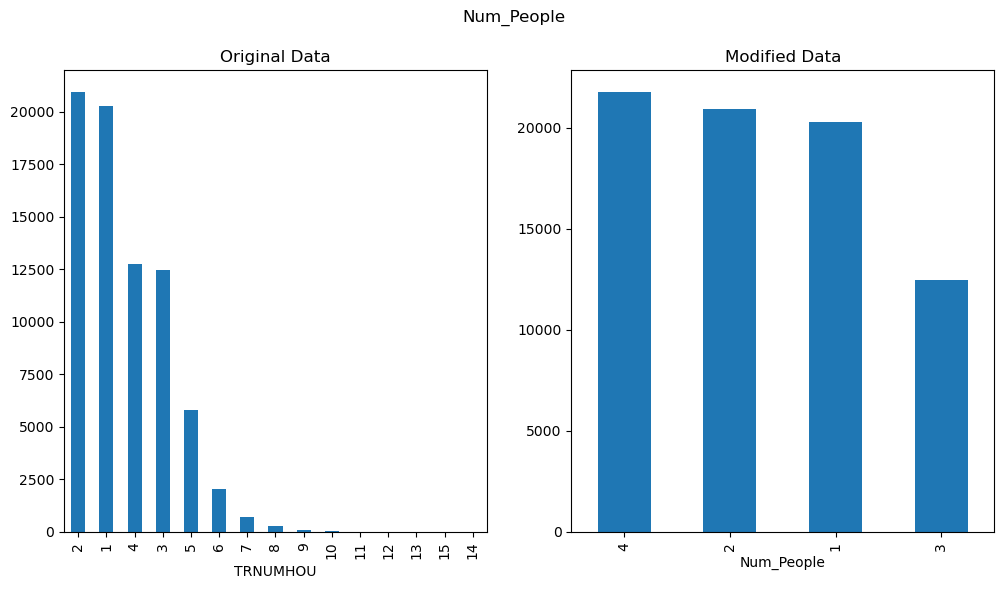

In [131]:
# Now comparing Num_People
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
full_data_old['TRNUMHOU'].value_counts().plot(kind='bar', ax=ax[0])
ax[0].set_title('Original Data')
full_data['Num_People'].value_counts().plot(kind='bar', ax=ax[1])
ax[1].set_title('Modified Data')
plt.suptitle('Num_People')
plt.show()

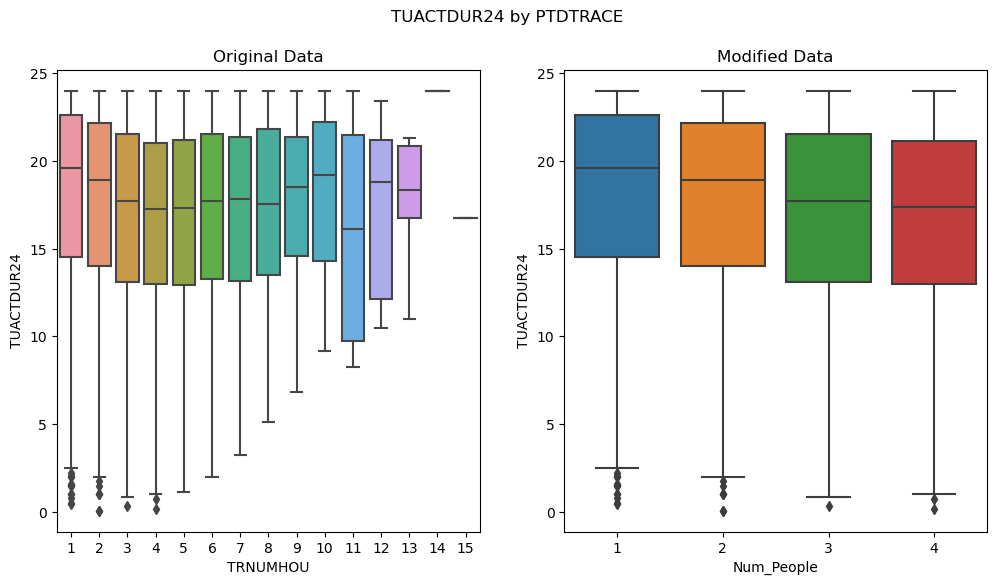

In [159]:
# Boxplots of TUACTDUR24 for Num_People (old vs new)
import seaborn as sns
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.boxplot(x='TRNUMHOU', y='TUACTDUR24', data=full_data_old, ax=ax[0])
ax[0].set_title('Original Data')
sns.boxplot(x='Num_People', y='TUACTDUR24', data=full_data, ax=ax[1])
ax[1].set_title('Modified Data')
plt.suptitle('TUACTDUR24 by PTDTRACE')
plt.show()

In [162]:
mask = full_data_old['TRNUMHOU'] == 11
full_data_old[mask]

,TEAGE,TELFS,TESEX,TRCHILDNUM,TRHHCHILD,TRHOLIDAY,TRNHHCHILD,TRNUMHOU,TROHHCHILD,TRSPPRES,...,HRHTYPE,PEHSPNON,PEEDUCA,PEMARITL,PRDISFLG,PTDTRACE,ageGroup,WEEKEND,TUACTDUR24,TUFINLWGT
1746,16,5,1,5,1,0,2,11,2,3,...,1,2,35,6,2,1,0-18,0,14.750000,1.909494e+07
5739,24,5,1,7,1,0,2,11,2,2,...,1,2,36,5,2,1,19-35,0,17.500000,2.014499e+07
13086,41,5,1,5,1,0,2,11,1,1,...,1,2,43,1,2,1,36-50,0,22.000000,1.715228e+07
1944,18,4,1,8,1,0,2,11,2,3,...,4,2,35,6,2,2,19-35,1,24.000000,7.970627e+06
4957,33,1,1,9,1,0,2,11,1,1,...,1,2,34,1,2,1,19-35,0,8.250000,1.871988e+07
7775,20,1,2,4,1,0,2,11,2,3,...,1,2,34,6,2,1,19-35,0,9.916667,7.545841e+07
4520,36,1,1,4,1,0,2,11,1,1,...,1,1,39,6,2,1,36-50,0,8.750000,4.073163e+07
8680,37,1,1,2,1,0,2,11,2,3,...,1,2,40,6,2,1,36-50,0,9.283333,2.797158e+07
2554,33,5,2,7,1,0,2,11,1,1,...,1,1,35,1,2,1,19-35,0,24.000000,1.522497e+07
3072,16,5,1,9,1,0,2,11,2,3,...,1,2,35,6,2,1,0-18,1,20.250000,9.019410e+06


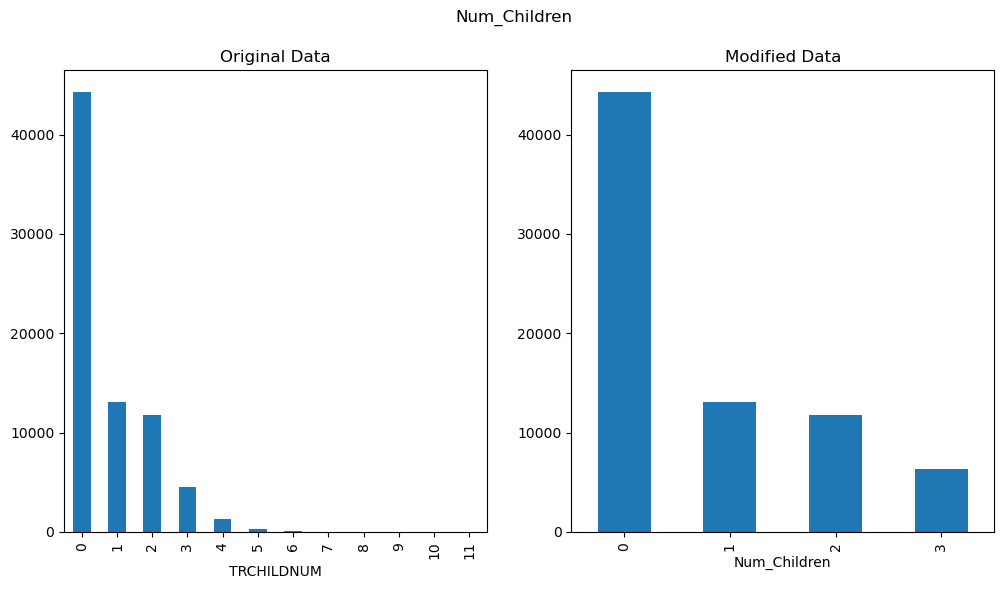

In [132]:
# Now comparing Num_Children
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
full_data_old['TRCHILDNUM'].value_counts().plot(kind='bar', ax=ax[0])
ax[0].set_title('Original Data')
full_data['Num_Children'].value_counts().plot(kind='bar', ax=ax[1])
ax[1].set_title('Modified Data')
plt.suptitle('Num_Children')   
plt.show()

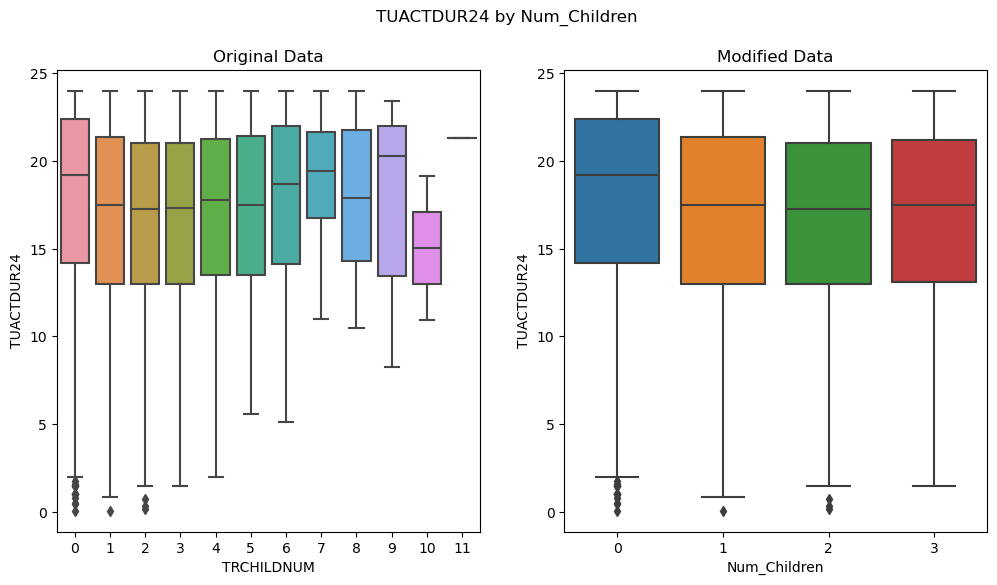

In [160]:
# Boxplots of TUACTDUR24 for Num_Children (old vs new)
import seaborn as sns
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.boxplot(x='TRCHILDNUM', y='TUACTDUR24', data=full_data_old, ax=ax[0])
ax[0].set_title('Original Data')
sns.boxplot(x='Num_Children', y='TUACTDUR24', data=full_data, ax=ax[1])
ax[1].set_title('Modified Data')
plt.suptitle('TUACTDUR24 by Num_Children')
plt.show()

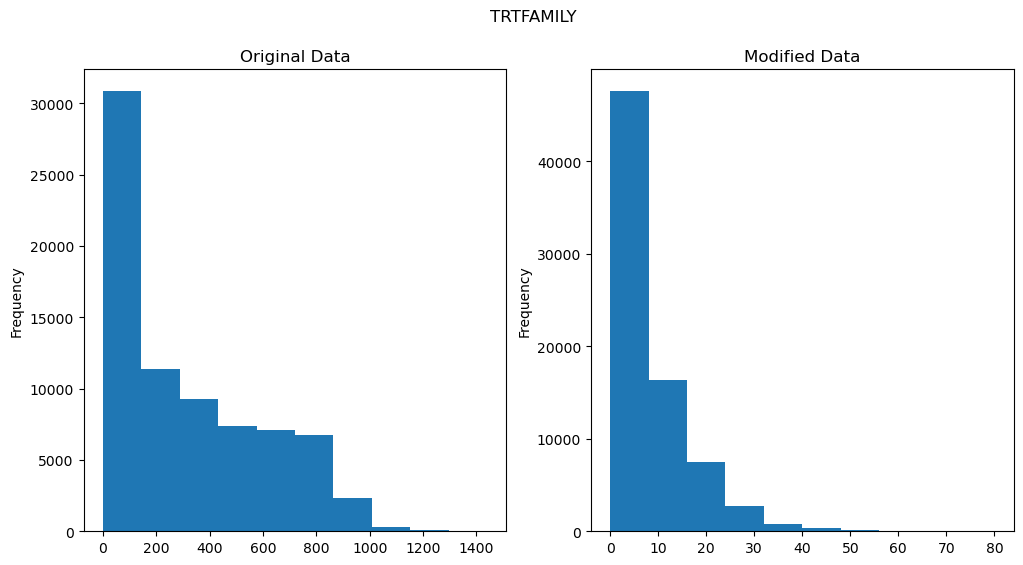

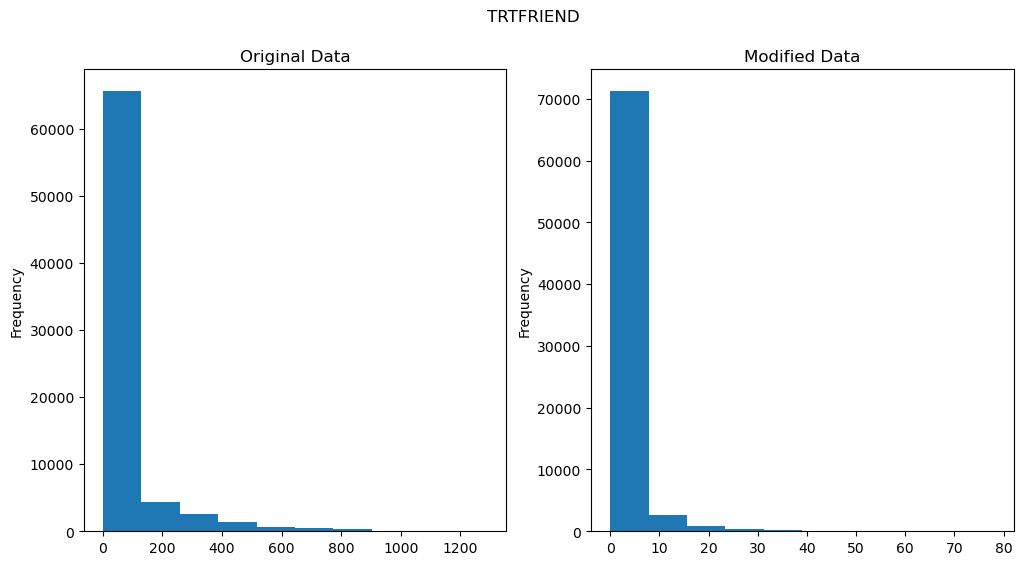

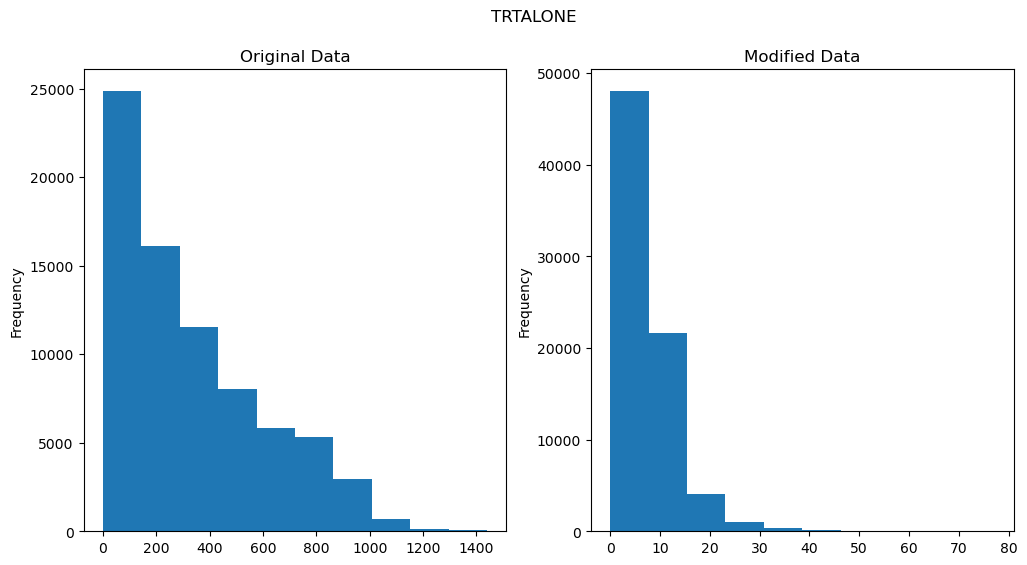

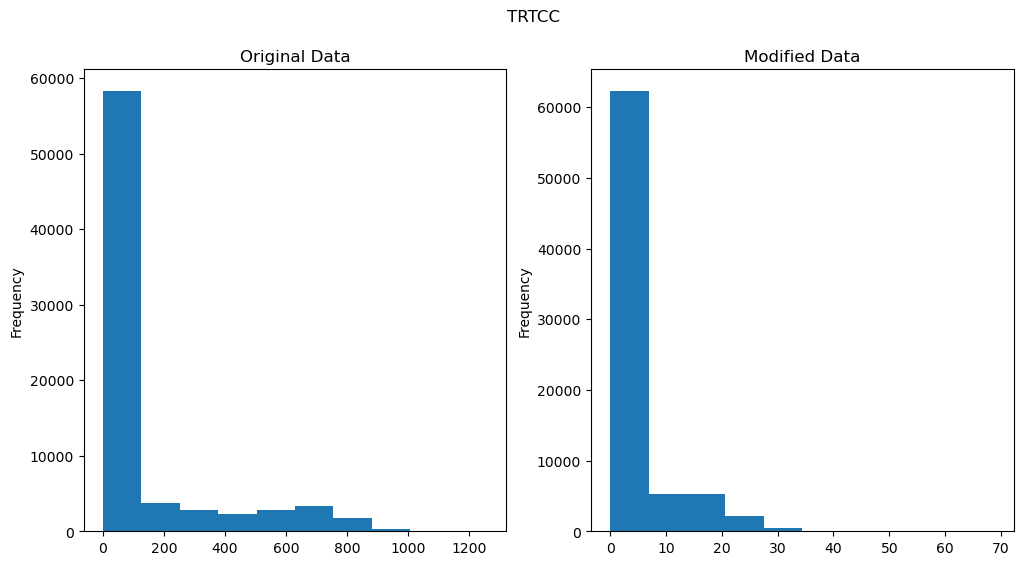

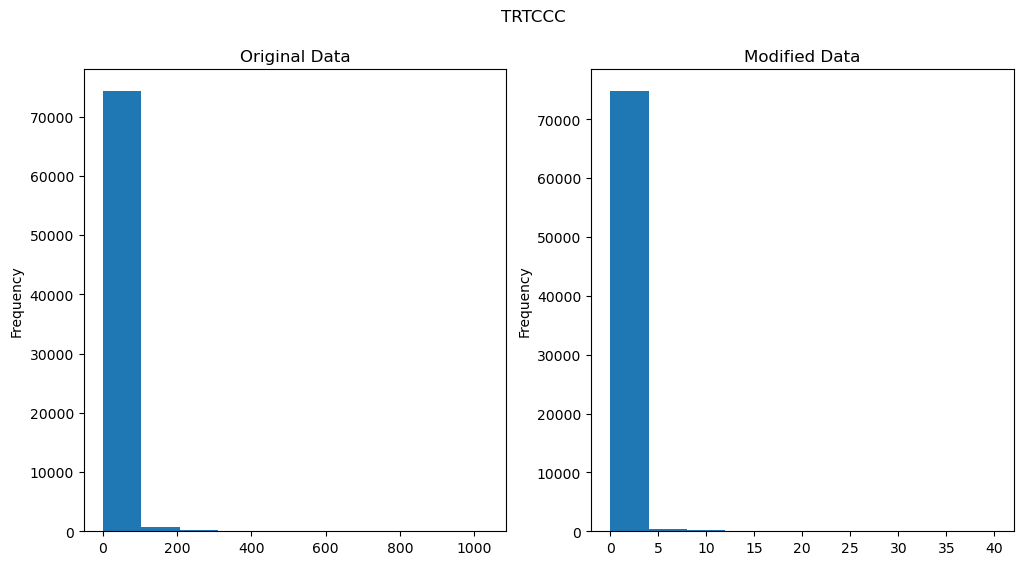

In [133]:
# Now comparing age normalized columns
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
full_data_old['TRTFAMILY'].plot(kind='hist', ax=ax[0])
ax[0].set_title('Original Data')
full_data['TRTFAMILY'].plot(kind='hist', ax=ax[1])
ax[1].set_title('Modified Data')
plt.suptitle('TRTFAMILY')

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
full_data_old['TRTFRIEND'].plot(kind='hist', ax=ax[0])
ax[0].set_title('Original Data')
full_data['TRTFRIEND'].plot(kind='hist', ax=ax[1])
ax[1].set_title('Modified Data')
plt.suptitle('TRTFRIEND')

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
full_data_old['TRTALONE'].plot(kind='hist', ax=ax[0])
ax[0].set_title('Original Data')
full_data['TRTALONE'].plot(kind='hist', ax=ax[1])
ax[1].set_title('Modified Data')
plt.suptitle('TRTALONE')

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
full_data_old['TRTCC'].plot(kind='hist', ax=ax[0])
ax[0].set_title('Original Data')
full_data['TRTCC'].plot(kind='hist', ax=ax[1])
ax[1].set_title('Modified Data')
plt.suptitle('TRTCC')

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
full_data_old['TRTCCC'].plot(kind='hist', ax=ax[0])
ax[0].set_title('Original Data')
full_data['TRTCCC'].plot(kind='hist', ax=ax[1])
ax[1].set_title('Modified Data')
plt.suptitle('TRTCCC')

plt.show()

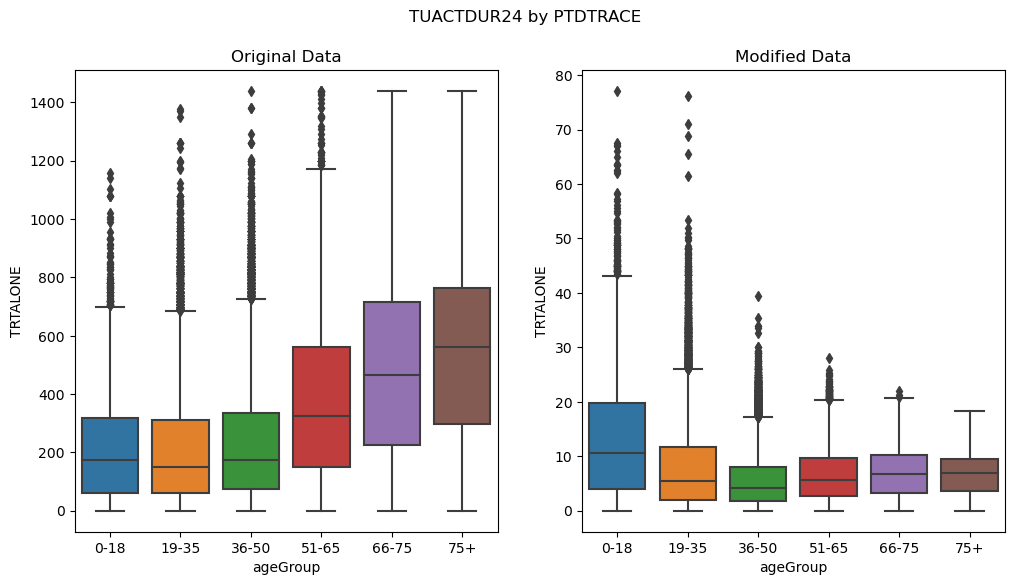

In [164]:
import seaborn as sns
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.boxplot(x='ageGroup', y='TRTALONE', data=full_data_old, ax=ax[0])
ax[0].set_title('Original Data')
sns.boxplot(x='ageGroup', y='TRTALONE', data=full_data, ax=ax[1])
ax[1].set_title('Modified Data')
plt.suptitle('TUACTDUR24 by PTDTRACE')
plt.show()

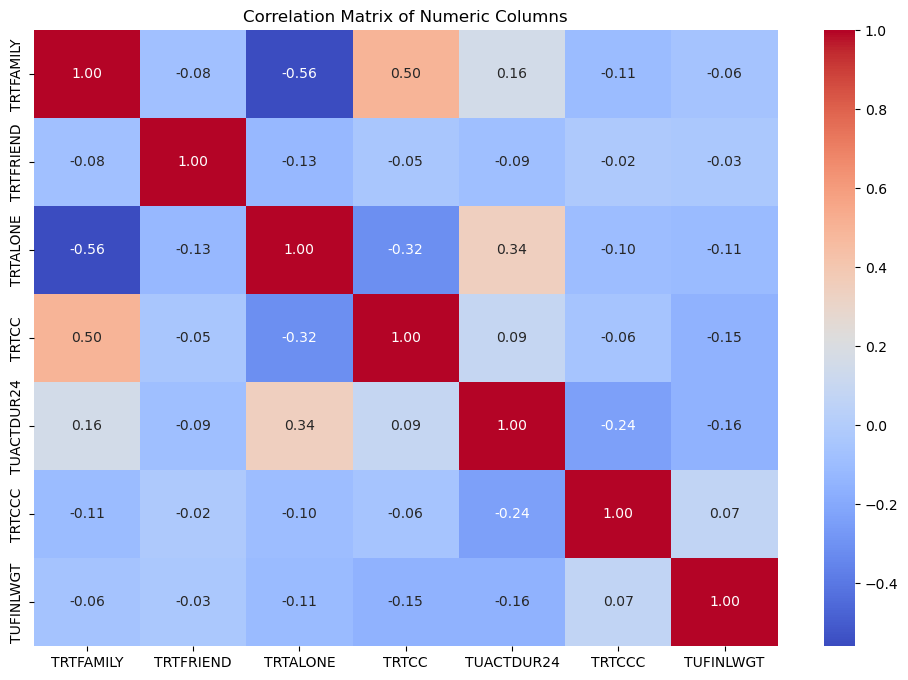

In [172]:
import seaborn as sns

# Calculate correlation of numeric columns
numeric_data = full_data[numeric_cols]
corr = numeric_data.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Columns')
plt.show()

## Preprocessing

In [173]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline

numeric_cols.remove('TUACTDUR24')
# Define preprocessing transformers
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder())
])

# Combine transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('ord', ordinal_transformer, ordinal_cols),
        ('cat', 'passthrough', cat_cols)
    ]
)

# Create the full pipeline with the preprocessor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Fit and transform the training data
X = full_data.drop(columns=['TUACTDUR24'])
y = full_data['TUACTDUR24']

In [174]:
X.columns

Index(['TEAGE', 'TELFS', 'TESEX', 'TRHHCHILD', 'TRHOLIDAY', 'TRNHHCHILD',
       'TROHHCHILD', 'TRSPPRES', 'TRTFAMILY', 'TRTFRIEND', 'TRTALONE', 'TRTCC',
       'TRTCCC', 'GEREG', 'GTMETSTA', 'HEFAMINC', 'HEHOUSUT', 'HRHTYPE',
       'PEHSPNON', 'PEEDUCA', 'PEMARITL', 'PRDISFLG', 'PTDTRACE', 'ageGroup',
       'WEEKEND', 'TUFINLWGT', 'Num_People', 'Num_Children', 'Num_Adults'],
      dtype='object')

In [175]:
X_preprocessed = pipeline.fit_transform(X)
# Convert the preprocessed data to a DataFrame
X_preprocessed = pd.DataFrame(X_preprocessed, columns=numeric_cols + ordinal_cols + cat_cols)
X_preprocessed.head()

,TRTFAMILY,TRTFRIEND,TRTALONE,TRTCC,TRTCCC,TUFINLWGT,PEEDUCA,ageGroup,HEFAMINC,Num_Children,...,WEEKEND,TESEX,HRHTYPE,PEHSPNON,TELFS,TRSPPRES,HEHOUSUT,PRDISFLG,PTDTRACE,GEREG
0,0.000000,0.000000,0.086806,0.000000,0.0,0.004719,2.0,1.0,0.0,3.0,...,1.0,2.0,4.0,2.0,1.0,3.0,1.0,2.0,0.0,1.0
1,0.184028,0.000000,0.215278,0.219841,0.0,0.010899,1.0,1.0,0.0,1.0,...,1.0,2.0,4.0,2.0,1.0,3.0,1.0,2.0,1.0,3.0
2,0.475694,0.000000,0.041667,0.558730,0.0,0.079585,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0
3,0.000000,0.000000,0.437500,0.000000,0.0,0.035864,2.0,4.0,0.0,0.0,...,0.0,2.0,7.0,2.0,5.0,3.0,1.0,2.0,0.0,4.0
4,0.091667,0.312403,0.218750,0.000000,0.0,0.015168,2.0,1.0,0.0,0.0,...,1.0,2.0,7.0,2.0,4.0,3.0,1.0,2.0,1.0,2.0


In [176]:
# Split for cross-validation
from sklearn.model_selection import GroupKFold

# Define the cross-validation splitter
cv = GroupKFold(n_splits=5)

In [187]:
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from sklearn.linear_model import Ridge, Lasso
import optuna
from sklearn.metrics import mean_squared_error

## Model 1 - Light Gradient Boosting Trees

In [178]:
# Define objective function for LightGBM

def objective(trial):
    # Define the hyperparameters to optimize
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.1, log=True),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),  # Corrected name
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),  # Corrected name
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "subsample": trial.suggest_float("subsample", 0.4, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 100),
        "random_state": 42
    }
    
    # Perform cross-validation
    scores = []
    for train_idx, valid_idx in cv.split(X_preprocessed, y, groups=X_preprocessed['ageGroup']):
        X_train, X_valid = X_preprocessed.iloc[train_idx], X_preprocessed.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model = lgb.LGBMRegressor(**params)
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
        y_pred = model.predict(X_valid)
        score = np.sqrt(np.mean((y_pred - y_valid)**2))
        scores.append(score)
    
    return np.mean(scores)

In [179]:
# Define the study
study = optuna.create_study(direction='minimize', study_name='lgbm_optimization')

# Optimize the study, with a timeout
study.optimize(objective, n_trials=20, timeout=3600)


print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
lgbm_trial = study.best_trial

print("  Value: {}".format(lgbm_trial.value))

print("  Params: ")
for key, value in lgbm_trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-11-21 18:05:15,833] A new study created in memory with name: lgbm_optimization
[I 2024-11-21 18:05:16,757] Trial 0 finished with value: 4.716829149409984 and parameters: {'learning_rate': 0.00045955146043602805, 'lambda_l1': 0.076498634214199, 'lambda_l2': 4.810740049207719e-06, 'max_depth': 2, 'subsample': 0.5599543808510161, 'colsample_bytree': 0.6549507531752047, 'min_child_weight': 88}. Best is trial 0 with value: 4.716829149409984.
[I 2024-11-21 18:05:17,595] Trial 1 finished with value: 3.724611445816359 and parameters: {'learning_rate': 0.013246168542126815, 'lambda_l1': 1.244060770920291e-07, 'lambda_l2': 0.9212240269594953, 'max_depth': 3, 'subsample': 0.8148243175574608, 'colsample_bytree': 0.7913584646561692, 'min_child_weight': 52}. Best is trial 1 with value: 3.724611445816359.
[I 2024-11-21 18:05:19,298] Trial 2 finished with value: 3.399307356017471 and parameters: {'learning_rate': 0.03750130981438528, 'lambda_l1': 4.481424903064009e-08, 'lambda_l2': 5.343706683

Number of finished trials: 20
Best trial:
  Value: 3.37127467425215
  Params: 
    learning_rate: 0.09876548930855931
    lambda_l1: 7.726804402932759
    lambda_l2: 1.035056683627003e-08
    max_depth: 9
    subsample: 0.7670137252191337
    colsample_bytree: 0.44258963032847864
    min_child_weight: 81


In [180]:
# Run the best LightGBM model
lgbm_params = lgbm_trial.params
lgbm_params['random_state'] = 42

lgbm_scores = []
lgbm_models = []

for train_idx, valid_idx in cv.split(X_preprocessed, y, groups=X_preprocessed['ageGroup']):
    X_train, X_valid = X_preprocessed.iloc[train_idx], X_preprocessed.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    model = lgb.LGBMRegressor(**lgbm_params)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
    y_pred = model.predict(X_valid)
    score = np.sqrt(mean_squared_error(y_valid, y_pred))
    lgbm_scores.append(score)
    lgbm_models.append(model)

lgbm_scores = np.array(lgbm_scores)
lgbm_rmse = np.mean(lgbm_scores)
lgbm_rmse_std = np.std(lgbm_scores)

print(f'LightGBM RMSE: {lgbm_rmse:.4f} +/- {lgbm_rmse_std:.4f}')

LightGBM RMSE: 3.3713 +/- 0.1992


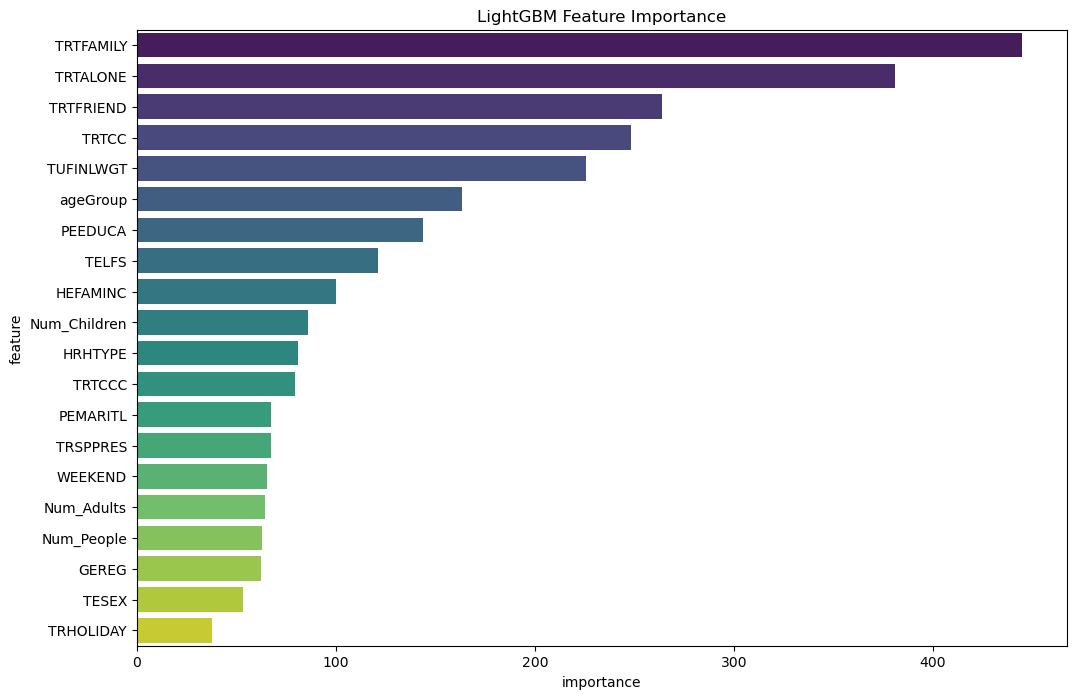

In [181]:
# Plot feature importance
lgbm_importances = np.zeros(X_preprocessed.shape[1])
for model in lgbm_models:
    lgbm_importances += model.feature_importances_

lgbm_importances /= len(lgbm_models)

lgbm_importances_df = pd.DataFrame({
    'feature': X_preprocessed.columns,
    'importance': lgbm_importances
})

lgbm_importances_df = lgbm_importances_df.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=lgbm_importances_df.head(20), x='importance', y='feature', palette='viridis')
plt.title('LightGBM Feature Importance')
plt.show()

## Model 2 - XGBoost Trees

In [182]:
# Define objective function for XGBoost

def objective(trial):
    # Define the hyperparameters to optimize
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'verbosity': 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.1, log=True),
        "lambda": trial.suggest_float("lambda", 1e-8, 10.0, log=True),  # L2 regularization
        "alpha": trial.suggest_float("alpha", 1e-8, 10.0, log=True),    # L1 regularization
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "subsample": trial.suggest_float("subsample", 0.4, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 100),
        "random_state": 42
    }
    
    # Perform cross-validation
    scores = []
    for train_idx, valid_idx in cv.split(X_preprocessed, y, groups=X_preprocessed['ageGroup']):
        X_train, X_valid = X_preprocessed.iloc[train_idx], X_preprocessed.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model = xgb.XGBRegressor(**params, n_estimators=1000, early_stopping_rounds=100)
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
        y_pred = model.predict(X_valid)
        score = np.sqrt(np.mean((y_pred - y_valid) ** 2))
        scores.append(score)
    
    return np.mean(scores)

In [183]:
# Define the study
study = optuna.create_study(direction='minimize', study_name='xgb_optimization')

# Optimize the study, with a timeout
study.optimize(objective, n_trials=20, timeout=3600)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
xgb_trial = study.best_trial

print("  Value: {}".format(xgb_trial.value))

print("  Params: ")
for key, value in xgb_trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-11-21 18:08:53,874] A new study created in memory with name: xgb_optimization
[I 2024-11-21 18:09:11,456] Trial 0 finished with value: 3.3647629204813834 and parameters: {'learning_rate': 0.019778315382106056, 'lambda': 0.003453884085021221, 'alpha': 4.379795828465649e-07, 'max_depth': 6, 'subsample': 0.9933570254889468, 'colsample_bytree': 0.8307805207153218, 'min_child_weight': 52}. Best is trial 0 with value: 3.3647629204813834.
[I 2024-11-21 18:09:24,300] Trial 1 finished with value: 4.059803301572012 and parameters: {'learning_rate': 0.001039133403097109, 'lambda': 0.4416529993739998, 'alpha': 0.1932784201368355, 'max_depth': 2, 'subsample': 0.9119930336213461, 'colsample_bytree': 0.40430316648978715, 'min_child_weight': 69}. Best is trial 0 with value: 3.3647629204813834.
[I 2024-11-21 18:09:39,114] Trial 2 finished with value: 3.4815287720940757 and parameters: {'learning_rate': 0.0037894774843464313, 'lambda': 0.9318915284392265, 'alpha': 0.011123843574226978, 'max_dept

Number of finished trials: 20
Best trial:
  Value: 3.34781431805376
  Params: 
    learning_rate: 0.02543015310895106
    lambda: 5.481353077529468e-05
    alpha: 0.00031995462177317093
    max_depth: 8
    subsample: 0.8072104421075232
    colsample_bytree: 0.7352210806631004
    min_child_weight: 66


In [184]:
# Run the best XGBoost model
xgb_params = xgb_trial.params
xgb_params['random_state'] = 42

xgb_scores = []
xgb_models = []

for train_idx, valid_idx in cv.split(X_preprocessed, y, groups=X_preprocessed['ageGroup']):
    X_train, X_valid = X_preprocessed.iloc[train_idx], X_preprocessed.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    model = xgb.XGBRegressor(**xgb_params, n_estimators=1000)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
    y_pred = model.predict(X_valid)
    score = np.sqrt(mean_squared_error(y_valid, y_pred))
    xgb_scores.append(score)
    xgb_models.append(model)

xgb_scores = np.array(xgb_scores)
xgb_rmse = np.mean(xgb_scores)
xgb_rmse_std = np.std(xgb_scores)

print(f'XGBoost RMSE: {xgb_rmse:.4f} +/- {xgb_rmse_std:.4f}')

XGBoost RMSE: 3.3551 +/- 0.1933


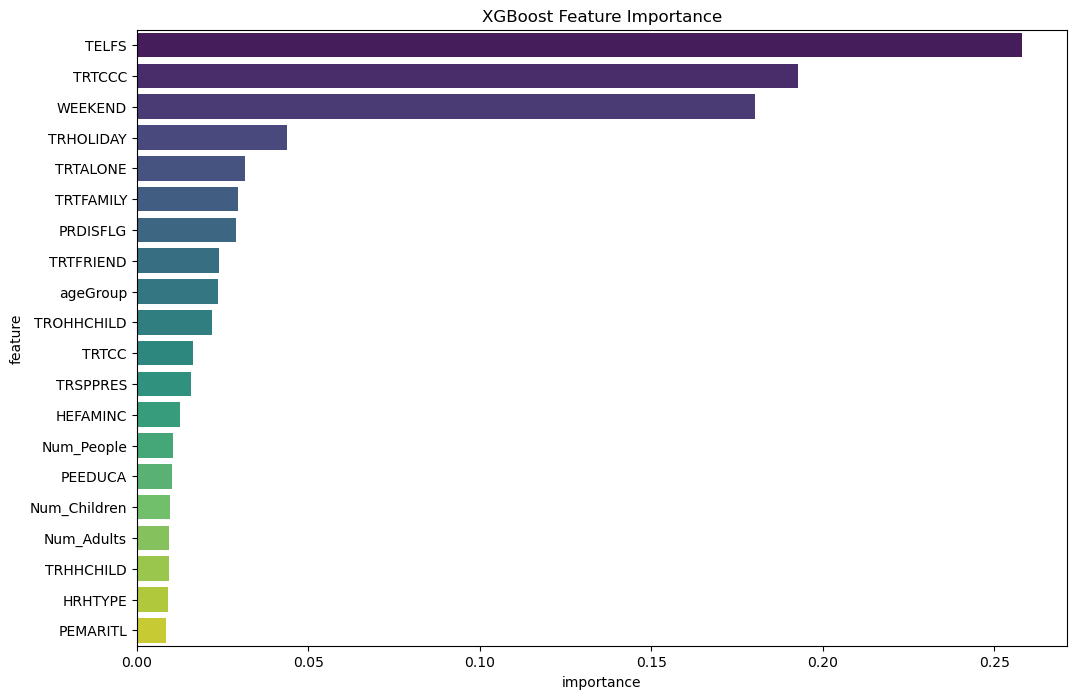

In [185]:
# Plot feature importance
xgb_importances = np.zeros(X_preprocessed.shape[1])
for model in xgb_models:
    xgb_importances += model.feature_importances_

xgb_importances /= len(xgb_models)

xgb_importances_df = pd.DataFrame({
    'feature': X_preprocessed.columns,
    'importance': xgb_importances
})

xgb_importances_df = xgb_importances_df.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=xgb_importances_df.head(20), x='importance', y='feature', palette='viridis')
plt.title('XGBoost Feature Importance')
plt.show()

## Model 3 - CatBoost

In [191]:
# Define objective function for CatBoost
def objective(trial):
    # Define the hyperparameters to optimize
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.1, log=True),
        "depth": trial.suggest_int("depth", 2, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 10.0, log=True),
        "random_strength": trial.suggest_float("random_strength", 0.1, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "verbose": 0,
        "random_state": 42,
    }
    
    # Perform cross-validation
    scores = []
    for train_idx, valid_idx in cv.split(X_preprocessed, y, groups=X_preprocessed['ageGroup']):
        X_train, X_valid = X_preprocessed.iloc[train_idx], X_preprocessed.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        # Initialize and train CatBoost model
        model = cb.CatBoostRegressor(**params)
        model.fit(
            X_train, 
            y_train, 
            eval_set=(X_valid, y_valid), 
            use_best_model=True, 
            early_stopping_rounds=50
        )
        # Make predictions and compute RMSE
        y_pred = model.predict(X_valid)
        score = np.sqrt(mean_squared_error(y_valid, y_pred))
        scores.append(score)
    
    # Return the mean RMSE across folds
    return np.mean(scores)

In [192]:
# Define the study
study = optuna.create_study(direction='minimize', study_name='cb_optimization')

# Optimize the study, with a timeout
study.optimize(objective, n_trials=20, timeout=3600)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
cb_trial = study.best_trial

print("  Value: {}".format(cb_trial.value))

print("  Params: ")
for key, value in cb_trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-11-21 18:24:36,702] A new study created in memory with name: cb_optimization
[I 2024-11-21 18:24:49,947] Trial 0 finished with value: 3.460463792482784 and parameters: {'iterations': 932, 'learning_rate': 0.011553528710411131, 'depth': 4, 'l2_leaf_reg': 0.4243325956162196, 'random_strength': 8.559203704628938, 'bagging_temperature': 0.5906119186218224, 'border_count': 186}. Best is trial 0 with value: 3.460463792482784.
[I 2024-11-21 18:24:55,887] Trial 1 finished with value: 4.678735832484715 and parameters: {'iterations': 409, 'learning_rate': 0.000162240575942727, 'depth': 4, 'l2_leaf_reg': 4.677866280641893e-06, 'random_strength': 9.470802754302952, 'bagging_temperature': 0.24099871051011956, 'border_count': 216}. Best is trial 0 with value: 3.460463792482784.
[I 2024-11-21 18:24:59,090] Trial 2 finished with value: 4.487901384224064 and parameters: {'iterations': 189, 'learning_rate': 0.000880206526920939, 'depth': 5, 'l2_leaf_reg': 3.9956606944829315e-07, 'random_strength

Number of finished trials: 20
Best trial:
  Value: 3.3606787276436116
  Params: 
    iterations: 768
    learning_rate: 0.03351022970963728
    depth: 9
    l2_leaf_reg: 0.008063241028332448
    random_strength: 5.1553362159147715
    bagging_temperature: 0.43069359835466625
    border_count: 116


In [193]:
# Run the best CatBoost model
cb_params = cb_trial.params
cb_params['random_state'] = 42

cb_scores = []
cb_models = []

for train_idx, valid_idx in cv.split(X_preprocessed, y, groups=X_preprocessed['ageGroup']):
    X_train, X_valid = X_preprocessed.iloc[train_idx], X_preprocessed.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    model = cb.CatBoostRegressor(**cb_params)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
    y_pred = model.predict(X_valid)
    score = np.sqrt(mean_squared_error(y_valid, y_pred))
    cb_scores.append(score)
    cb_models.append(model)

cb_scores = np.array(cb_scores)
cb_rmse = np.mean(cb_scores)
cb_rmse_std = np.std(cb_scores)

print(f'CatBoost RMSE: {cb_rmse:.4f} +/- {cb_rmse_std:.4f}')

CatBoost RMSE: 3.3606 +/- 0.1987


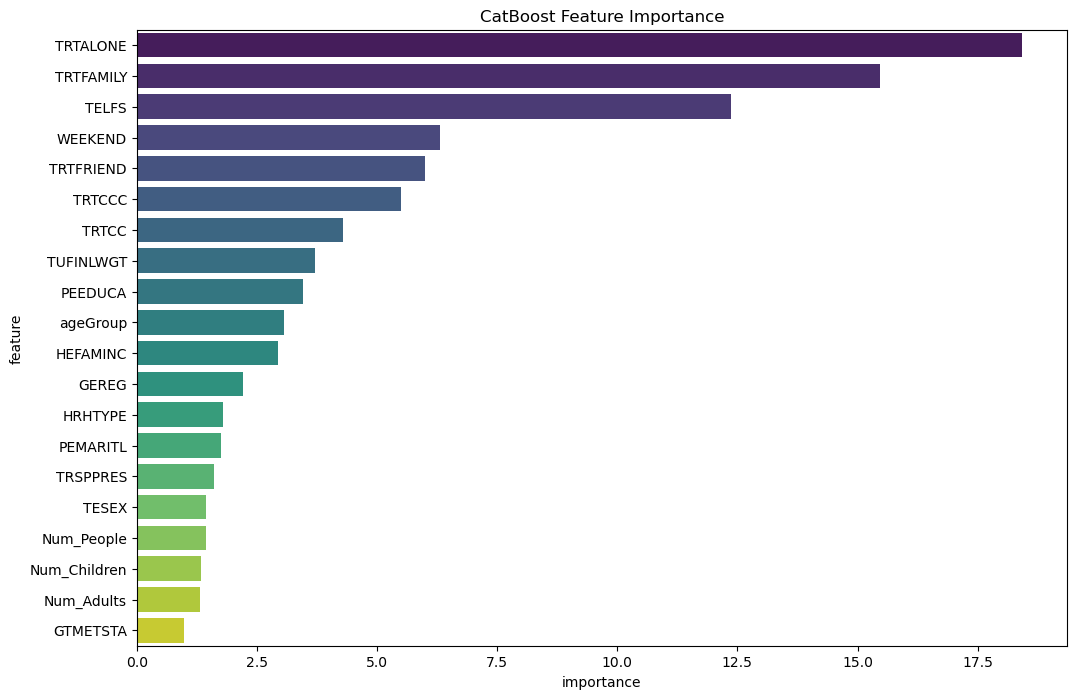

In [194]:
# Plot feature importance
cb_importances = np.zeros(X_preprocessed.shape[1])
for model in cb_models:
    cb_importances += model.feature_importances_

cb_importances /= len(cb_models)

cb_importances_df = pd.DataFrame({
    'feature': X_preprocessed.columns,
    'importance': cb_importances
})

cb_importances_df = cb_importances_df.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=cb_importances_df.head(20), x='importance', y='feature', palette='viridis')
plt.title('CatBoost Feature Importance')
plt.show()

# Comparing the Models

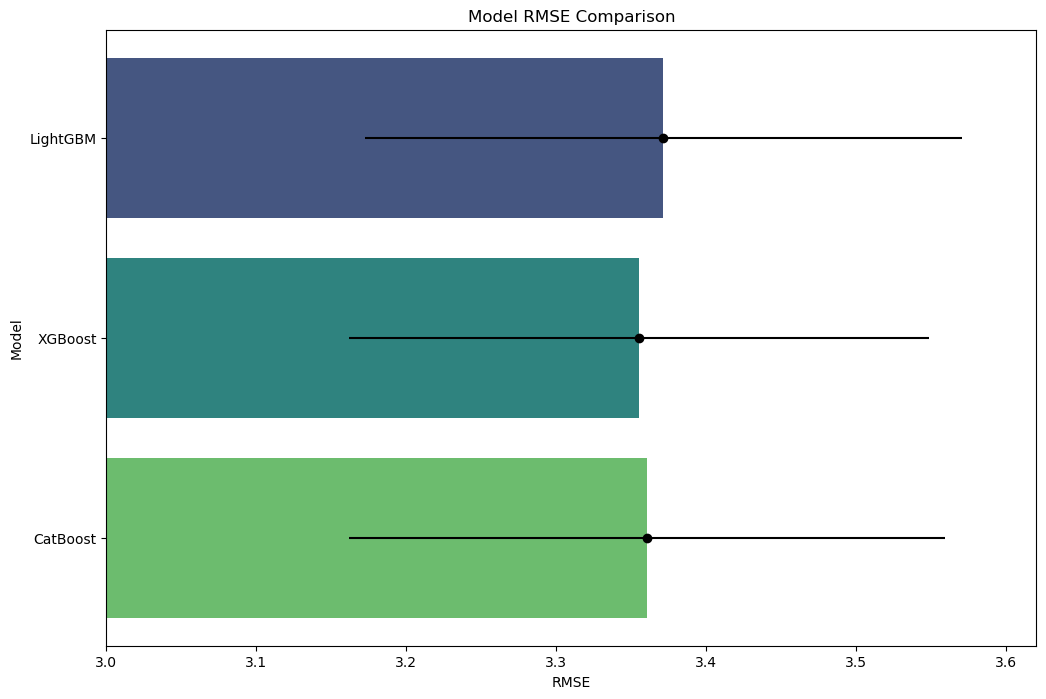

In [198]:
# Compare the RMSE of the models

model_names = ['LightGBM', 'XGBoost', 'CatBoost']
model_rmse = [lgbm_rmse, xgb_rmse, cb_rmse]
model_std = [lgbm_rmse_std, xgb_rmse_std, cb_rmse_std]

plt.figure(figsize=(12, 8))
sns.barplot(x=model_rmse, y=model_names, palette='viridis')
plt.errorbar(x=model_rmse, y=model_names, xerr=model_std, fmt='o', color='black')
plt.title('Model RMSE Comparison')
plt.xlabel('RMSE')
plt.ylabel('Model')
plt.xlim(3, 3.62)
plt.show()

* XGBoost marginally beats out the other two models for accuracy. However, LightGBM has the fastest inference time by far. CatBoost has the second best accuracy but the slowest inference time.

* Each model ranks features differently. Each of these models can be used as a substitue for the p-value pipeline previously built. Unlike linear regression, these tree models handle categorical data natively and therefore does not require one-hot encoding. This increases interpretability of the features greatly. 

* Another approach would be to combine the three models into one VotingRegressor - it creates a mixed output by listening to each model. This would also result in a mixed feature importance, reducing the bias of any one model in future decision making.

# Combining the three models into one

In [200]:
# Combine the models into a voting regressor
from sklearn.ensemble import VotingRegressor

voting_scores = []
voting_models = []

for i, (train_idx, valid_idx) in enumerate(cv.split(X_preprocessed, y, groups=X_preprocessed['ageGroup'])):
    X_train, X_valid = X_preprocessed.iloc[train_idx], X_preprocessed.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    model = VotingRegressor([
        ('lgbm', lgbm_models[i]),
        ('xgb', xgb_models[i]),
        ('ridge', cb_models[i])
    ])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    score = np.sqrt(mean_squared_error(y_valid, y_pred))
    voting_scores.append(score)
    voting_models.append(model)

voting_scores = np.array(voting_scores)
voting_rmse = np.mean(voting_scores)
voting_rmse_std = np.std(voting_scores)

print(f'Voting Regressor RMSE: {voting_rmse:.4f} +/- {voting_rmse_std:.4f}')

0:	learn: 4.6326447	total: 10.6ms	remaining: 8.15s
1:	learn: 4.5777876	total: 15ms	remaining: 5.76s
2:	learn: 4.5239192	total: 24.3ms	remaining: 6.19s
3:	learn: 4.4673556	total: 33.5ms	remaining: 6.39s
4:	learn: 4.4134638	total: 42.6ms	remaining: 6.49s
5:	learn: 4.3667305	total: 51.7ms	remaining: 6.57s
6:	learn: 4.3182409	total: 60.7ms	remaining: 6.59s
7:	learn: 4.2757358	total: 70.4ms	remaining: 6.69s
8:	learn: 4.2312821	total: 79.6ms	remaining: 6.71s
9:	learn: 4.1901784	total: 88.7ms	remaining: 6.72s
10:	learn: 4.1506031	total: 97.7ms	remaining: 6.72s
11:	learn: 4.1127196	total: 107ms	remaining: 6.76s
12:	learn: 4.0783483	total: 117ms	remaining: 6.78s
13:	learn: 4.0462438	total: 126ms	remaining: 6.76s
14:	learn: 4.0191286	total: 135ms	remaining: 6.76s
15:	learn: 3.9900843	total: 144ms	remaining: 6.76s
16:	learn: 3.9607932	total: 154ms	remaining: 6.78s
17:	learn: 3.9340305	total: 163ms	remaining: 6.79s
18:	learn: 3.9095677	total: 172ms	remaining: 6.8s
19:	learn: 3.8827883	total: 181ms

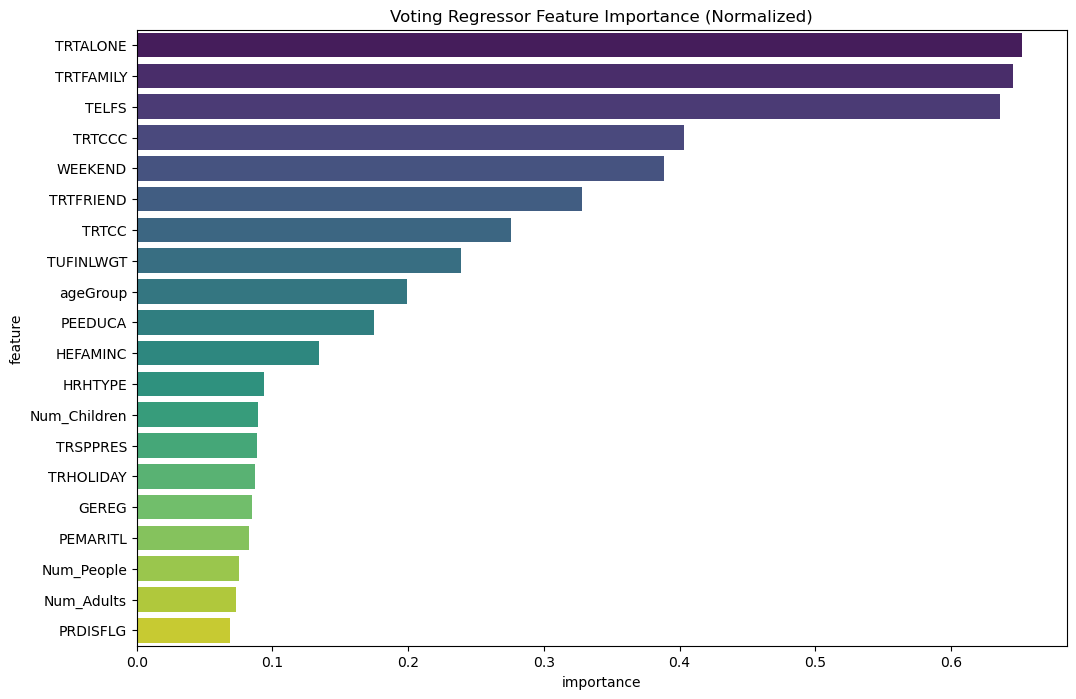

In [203]:
from sklearn.preprocessing import MinMaxScaler
# Initialize total feature importance array
voting_importances = np.zeros(X_preprocessed.shape[1])

# Initialize MinMaxScaler
scaler = MinMaxScaler()

for model in voting_models:
    for est in model.estimators_:
        # Get feature importances from each estimator
        if hasattr(est, 'feature_importances_'):
            feature_importances = est.feature_importances_
        elif hasattr(est, 'get_feature_importance'):
            feature_importances = est.get_feature_importance()
        else:
            raise ValueError(f"Estimator {type(est).__name__} does not support feature importance retrieval.")
        
        # Normalize feature importances to [0, 1]
        feature_importances = scaler.fit_transform(feature_importances.reshape(-1, 1)).flatten()
        
        # Add to the aggregate importances
        voting_importances += feature_importances

# Average the feature importances across all estimators
voting_importances /= (len(voting_models) * len(model.estimators_))

# Create a DataFrame for feature importances
voting_importances_df = pd.DataFrame({
    'feature': X_preprocessed.columns,
    'importance': voting_importances
}).sort_values('importance', ascending=False)

# Plot the top 20 features
plt.figure(figsize=(12, 8))
sns.barplot(data=voting_importances_df.head(20), x='importance', y='feature', palette='viridis')
plt.title('Voting Regressor Feature Importance (Normalized)')
plt.show()

In [204]:
# Save the models

import joblib

# Save the models
joblib.dump(lgbm_models[0], 'lgbm_model.pkl')
joblib.dump(xgb_models[0], 'xgb_model.pkl')
joblib.dump(cb_models[0], 'ridge_model.pkl')
joblib.dump(voting_models[0], 'voting_model.pkl')

# Save the preprocessor
joblib.dump(pipeline, 'preprocessor.pkl')

# Save the feature importances
lgbm_importances_df.to_csv('lgbm_importances.csv', index=False)
xgb_importances_df.to_csv('xgb_importances.csv', index=False)
cb_importances_df.to_csv('ridge_importances.csv', index=False)
voting_importances_df.to_csv('voting_importances.csv', index=False)

## Conclusions

- The best models predict the time spent at home with an error of ~3.3 hours. Comparing this to the standard deviation of ~4.8 hours, there is some benefit to using such a model. However, in my analysis, there seems to be a lot of random noise in the data and not enough discernable patterns for these models to recognize. 

- Future efforts should inclue novel ways to select what features to put in - the current approach is simply selecting those variables that are defined for all respondents. 

- The other question is of including columns such as "time spent alone" and "time spent with family" - how prudent is it to predict time spent at home with other columns that contain time information? For a real-life application of such a model, would such information be readily available? If yes, then wouldn't time spent at home also be available, rendering this model redundant? There is a separate notebook where I have trained similar models without these features. The performance of these models drops significantly, from ~3.3 to ~3.9 hours.

- Finally, what about the weights in the dataset? How are they used in this context? The User guide advises to use the weights, but only gives examples of calculating averages. What about when we are trying to predict total time spent at home? Simply including the weight as a feature in the model seems to have minimal impact, especially when not using the time features. The RMSE with weight as a feature was 3.9060, and without weight was 3.9043 - a minimal improvement.